# YouTube trending videos

In [3]:
%matplotlib inline

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from numpy import nan

from typing import List
# import re
# from IPython.display import Image

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 3 - Ocena ważności atrybutów


### Wczytanie danych zgrupowanych po id

TODO trending days

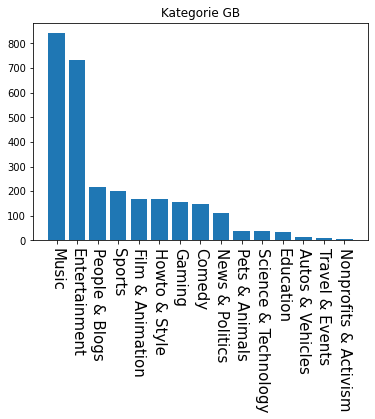

Kategorie GB Liczba wartości 'nan':394


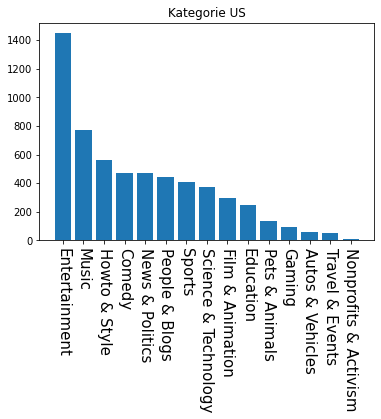

Kategorie US Liczba wartości 'nan':494


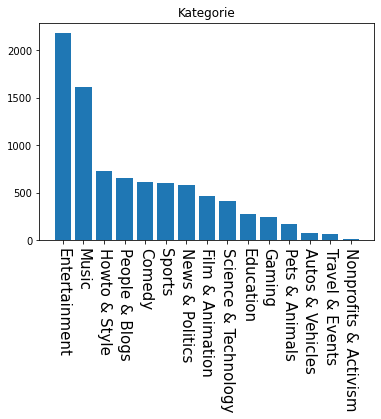

Kategorie Liczba wartości 'nan':888


In [4]:
numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day"
]


def plot_categories(title: str, categories_dict: dict, data: pd.DataFrame) -> list:
    nan_count = data["new_category_id"].isna().sum()
    plt.title(title)
    attr_c = data["new_category_id"].value_counts()
    attr_c = attr_c.rename_axis("new_category_id").reset_index(name="count")
    labels = [categories_dict[i] for i in attr_c["new_category_id"]]
    plt.bar(labels, attr_c["count"])
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

    print(f"{title} Liczba wartości 'nan':{nan_count}")
    return attr_c["new_category_id"].tolist()


data_dir = "ped3_data"
gb_videos, us_videos = load_csv(data_dir)
videos = pd.concat([gb_videos, us_videos])
for name in numeric_attrs:
    videos[name] = videos[name].apply(lambda x: eval(x))
videos.head(10)

categorical_attrs = ["video_id", "thumbnail_link", "comments_disabled", "ratings_disabled", "video_error_or_removed",
                     "trending_date"]

for name in categorical_attrs:
    videos[name] = videos[name].apply(lambda x: eval(x)[-1] if eval(x) else np.nan)

categories_dict = get_categories_dict()

d = [gb_videos, us_videos]
names = ["Kategorie GB", "Kategorie US"]
for df, name in zip(d, names):
    plot_categories(name, categories_dict, df)
categories = plot_categories("Kategorie", categories_dict, videos)


Patrząc na wykresy kategorii o można zauważyć znaczne różnice
pomiędzy wielkością zbiorów filmów w poszczególnych kategoriach. Takie
niezbalansowanie będzie trzeba mieć na uwadze, przechodząc do kolejnego
etapu przy uczeniu modeli.

In [32]:
for i in numeric_attrs:
    videos[i] = videos[i].apply(lambda x: x[-1])
videos["category_name"] = videos["new_category_id"].apply(lambda x: np.nan if np.isnan(x) else categories_dict[x])
grouped = videos.groupby("category_name")

grouped.agg([np.mean, np.std])
# videos.describe()

.233410   
Gaming                                               0.012195  0.109980   
Howto & Style                                        0.000000  0.000000   
Music                                                0.000000  0.000000   
News & Politics                                      0.000000  0.000000   
Nonprofits & Activism                                0.000000  0.000000   
People & Blogs                                       0.000000  0.000000   
Pets & Animals                                       0.000000  0.000000   
Science & Technology                                 0.000000  0.000000   
Sports                                               0.000000  0.000000   
Travel & Events                                      0.000000  0.000000   

                      freq_filtered_ocr_text_Autos & Vehicles            \
                                                         mean       std   
category_name                                                             
Autos & Vehicles                                     0.013699  0.117041   
Comedy                                               0.000000  0.000000   
Education                                            0.000000  0.000000   
Entertainment                                        0.000000  0.000000   
Film & Animation                                     0.000000  0.000000   
Gaming                                               0.000000  0.000000   
Howto & Style                                        0.000000  0.000000   
Music                                                0.000000  0.000000   
News & Politics                                      0.000000  0.000000   
Nonprofits & Activism                                0.000000  0.000000   
People & Blogs                                       0.000000  0.000000   
Pets & Animals                                       0.000000  0.000000   
Science & Technology                                 0.000000  0.000000   
Sports                                               0.000000  0.000000   
Travel & Events                                      0.000000  0.000000   

                      freq_filtered_ocr_text_Nonprofits & Activism            \
                                                              mean       std   
category_name                                                                  
Autos & Vehicles                                          0.000000  0.000000   
Comedy                                                    0.000000  0.000000   
Education                                                 0.000000  0.000000   
Entertainment                                             0.000459  0.021418   
Film & Animation                                          0.000000  0.000000   
Gaming                                                    0.000000  0.000000   
Howto & Style                                             0.000000  0.000000   
Music                                                     0.000000  0.000000   
News & Politics                                           0.001721  0.041487   
Nonprofits & Activism                                     0.111111  0.323381   
People & Blogs                                            0.000000  0.000000   
Pets & Animals                                            0.000000  0.000000   
Science & Technology                                      0.000000  0.000000   
Sports                                                    0.000000  0.000000   
Travel & Events                                           0.000000  0.000000   

                      freq_filtered_ocr_text_Shows       \
                                              mean  std   
category_name                                             
Autos & Vehicles                               0.0  0.0   
Comedy                                         0.0  0.0   
Education                                      0.0  0.0   
Entertainment                                  0.0  0.0   
Film & Animation                 

# Atrybuty numeryczne

Korelacja atrybutów liczbowych z kategorią

Atrybuty numeryczne zostały ocenione za pomocą analizy wariancji (ANOVA Analysis of Variance).
Zastosowana metoda wynika z tego, że mamy jednym z atrybutów jest atrybut
nominalny - *category_id*.

Przyjęte hipotezy:

$$ H_0 $$: Średnie w poszczególnych kategoriach są takie same.

$$ H_1 $$: Średnie w poszczególnych kategoriach są różne.

Przyjęty poziom istotności: $$ \alpha = 0.05 $$

In [4]:
categories_data = []
N = 0
a = len(categories)
for category_id in categories:
    c_data = videos[videos["new_category_id"] == category_id]
    N += len(c_data)
    categories_data.append(c_data)

dfn = a - 1
dfd = N - a


def anova(data: List[pd.DataFrame], attr: str):
    data_set = list(map(lambda x: x[attr].dropna(), data))
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    print(f"{attr}: f_score = {f_score} p_value = {p_value}")
    plt.title(attr)
    plt.boxplot(data_set, showfliers=False)
    labels = [categories_dict[i] for i in categories]
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=270, fontsize=15)
    plt.show()
    return f_score, p_value


f_scores = pd.DataFrame()
alpha = 0.05
for i in numeric_attrs:
    f, p = anova(categories_data, i)
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [i], "f score": [f], "p value": [p], "leq alpha": [p <= alpha]}
    ), ignore_index=True)
print(stats.f.ppf(0.05, dfn, dfd))
f_scores

ValueError: 

Poszczególne kategorie mają różne średnie wartości na wszystkich atrybutach.

## Ocena atrybutów tekstowych

Po podaniu tekstów procesowi tokenizacji zostały wygenerowane dla nich cechy
numeryczne, które wyrażają liczbę występujących częstych tokenów przez liczbę wszyskich
często występujących tokenów dla każdej kategorii na każdym atrybucie.

In [ ]:
tokenized_attrs = ["channel_titles", "descriptions", "ocr_text", "titles", "domains", "filtered_ocr_text"]
frequent_attrs = list(filter(lambda x: x.startswith("freq_"), videos.columns.tolist()))
print(frequent_attrs)

## Tytuł kanału

In [ ]:
attr = "channel_titles"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## Tytuł filmu

In [31]:
attr = "titles"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)


NameError: name 'anova' is not defined

## Opisy filmów

In [ ]:
attr = "descriptions"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## OCR

In [ ]:
attr = "ocr_text"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## Filtered OCR

In [ ]:
attr = "filtered_ocr_text"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## Domeny

In [ ]:
attr = "domains"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## TAGI

In [ ]:
attr = "tags"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)


## Emocje

In [30]:
videos["tokenized_emotion"] = videos["emotions"].apply(lambda x: [eval(x)[-1]] if eval(x) else np.nan)
# plot_categories_bars(categories, "emotion", create_tokens_dict=False)

## Video_id

In [29]:
contingency = pd.crosstab(videos["video_id"], videos["category_name"], normalize="index")

_, p, _, _ = stats.chi2_contingency(contingency)

print(f"p value: {p}")

p value: 0.4996536423717098


P wartość nie pozwala na odrzucenie hipotezy zerowej, zatem nie występuje zależność
kontyngencja między atrybutem kategorii a *video_id*. Jest to spodziewany wynik,
ponieważ atrybut ten pozwala jedynie unikalnie identyfikować filmy, nie wnosi on żadnej
wiedzy na temat zawartości filmu, co za tym idzie o przynależności do danej kategorii.

## New video id

Atrybut, który został wyznaczony z obrobionych linków *thumbnail_link* oraz *video_id*.

In [28]:
contingency = pd.crosstab(videos["new_video_id"], videos["category_name"], normalize="index")

_, p, _, _ = stats.chi2_contingency(contingency)

print(f"p value: {p}")

p value: 0.47858893101950944


Podobnie jak w przypadku oryginalnego identyfikatora z danych nie występuje zależność
pomiędzy nim a kategorią, do której należy reprezentowany przez niego film. Jest to także
spodziewany wynik oceny przydatności atrybutu.

## Thumbnail link

In [27]:
contingency = pd.crosstab(videos["thumbnail_link"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.47858893101950944


Podobnie jak dwa atrybuty odpowiadające za identyfikację filmu także
dla atrybutu *thumbnail link* nie występuje istotna statystycznie zależność
pomiędzy nim oraz kategorią, do której należy film. Także jak dwa poprzednie atrybuty
nie będzie on używany podczas uczenia modeli.

## Comments disabled

In [23]:
contingency = pd.crosstab(videos["comments_disabled"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.9999999994265536


Także ten atrybut nie pozwala dobrze wnioskować o przynależności do poszczególnych
kategorii filmów. Podobnie nie można odrzucić $$ H_0 $$ na rzecz $$ H_1 $$.
Jest to także przewidziany wynik, nie mniej ten atrybut może być przydatny,
kiedy przyjdzie rozróżniać pomiędzy filmami trening i nie trending.

## Ratings disabled

In [24]:
contingency = pd.crosstab(videos["ratings_disabled"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.9999999958104572


Atrybut *ratings_disabled* to kolejny atrybut logiczny, który nie będzie
używany podczas uczenia pół nadzorowanego. Tutaj także nie występuje zależność
pomiędzy nim a kategorią, do której należy film. Podobanie jak poprzeni atrybut
także może okazać się przydatny w rozpoznawaniu filmów trending, taka analiza
zostanie przeprowadzona w etapie 5.

## Video error or removed

In [25]:
contingency = pd.crosstab(videos["video_error_or_removed"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.9999998090641606


Kolejny atrybut, który od samego początku wydawał się nieistotny z punktu
widzenia rozróżniania kategorii filmu. Także nie możemy odrzucić
hipotezy $$ H_0 $$ mówiącej o niezależności tych atrybutów. Podobnie jak poprzednie
atrybuty logiczne ten atrybut może okazać się istotny w etapie 5.

## Trending date - trending_date

In [26]:
contingency = pd.crosstab(videos["trending_date"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 1.0


## Publish time - publish_time

In [5]:
contingency = pd.crosstab(videos["publish_time"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.521342786297252


In [33]:
videos

,new_video_id,Unnamed: 0.1,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,movie_domains_count,description_len,title_len,channel_title_len,trending_date_day_of_week,publish_time_day_of_week,publish_time_hour_of_day,count,new_category_id,tokenized_channel_titles,tokenized_descriptions,tokenized_ocr_text,tokenized_titles,tokenized_domains,tokenized_filtered_ocr_text,obj_names,obj_scores,emotions,colors,cropped_colors,gray_mean_score,color_mean_score,gray_hist_score,red_hist_score,green_hist_score,blue_hist_score,edges_score,entropy_score,vevo,category_name,tokenized_tags,tokenized_emotion,tokenized_objects,tokenized_colors,freq_channel_titles_Entertainment,freq_channel_titles_Music,freq_channel_titles_People & Blogs,freq_channel_titles_Howto & Style,freq_channel_titles_News & Politics,freq_channel_titles_Comedy,freq_channel_titles_Sports,freq_channel_titles_Travel & Events,freq_channel_titles_Gaming,freq_channel_titles_Education,freq_channel_titles_Pets & Animals,freq_channel_titles_Science & Technology,freq_channel_titles_Film & Animation,freq_channel_titles_Autos & Vehicles,freq_channel_titles_Nonprofits & Activism,freq_channel_titles_Shows,freq_descriptions_Entertainment,freq_descriptions_Music,freq_descriptions_People & Blogs,freq_descriptions_Howto & Style,freq_descriptions_News & Politics,freq_descriptions_Comedy,freq_descriptions_Sports,freq_descriptions_Travel & Events,freq_descriptions_Gaming,freq_descriptions_Education,freq_descriptions_Pets & Animals,freq_descriptions_Science & Technology,freq_descriptions_Film & Animation,freq_descriptions_Autos & Vehicles,freq_descriptions_Nonprofits & Activism,freq_descriptions_Shows,freq_ocr_text_Entertainment,freq_ocr_text_Music,freq_ocr_text_People & Blogs,freq_ocr_text_Howto & Style,freq_ocr_text_News & Politics,freq_ocr_text_Comedy,freq_ocr_text_Sports,freq_ocr_text_Travel & Events,freq_ocr_text_Gaming,freq_ocr_text_Education,freq_ocr_text_Pets & Animals,freq_ocr_text_Science & Technology,freq_ocr_text_Film & Animation,freq_ocr_text_Autos & Vehicles,freq_ocr_text_Nonprofits & Activism,freq_ocr_text_Shows,freq_titles_Entertainment,freq_titles_Music,freq_titles_People & Blogs,freq_titles_Howto & Style,freq_titles_News & Politics,freq_titles_Comedy,freq_titles_Sports,freq_titles_Travel & Events,freq_titles_Gaming,freq_titles_Education,freq_titles_Pets & Animals,freq_titles_Science & Technology,freq_titles_Film & Animation,freq_titles_Autos & Vehicles,freq_titles_Nonprofits & Activism,freq_titles_Shows,freq_domains_Entertainment,freq_domains_Music,freq_domains_People & Blogs,freq_domains_Howto & Style,freq_domains_News & Politics,freq_domains_Comedy,freq_domains_Sports,freq_domains_Travel & Events,freq_domains_Gaming,freq_domains_Education,freq_domains_Pets & Animals,freq_domains_Science & Technology,freq_domains_Film & Animation,freq_domains_Autos & Vehicles,freq_domains_Nonprofits & Activism,freq_domains_Shows,freq_filtered_ocr_text_Entertainment,freq_filtered_ocr_text_Music,freq_filtered_ocr_text_People & Blogs,freq_filtered_ocr_text_Howto & Style,freq_filtered_ocr_text_News & Politics,freq_filtered_ocr_text_Comedy,freq_filtered_ocr_text_Sports,freq_filtered_ocr_text_Travel & Events,freq_filtered_ocr_text_Gaming,freq_filtered_ocr_text_Education,freq_filtered_ocr_text_Pets & Animals,freq_filtered_ocr_text_Science & Technology,freq_filtered_ocr_text_Film & Animation,freq_filtered_ocr_text_Autos & Vehicles,freq_filtered_ocr_text_Nonprofits & Activism,freq_filtered_ocr_text_Shows,freq_tags_Entertainment,freq_tags_Music,freq_tags_People & Blogs,freq_tags_Howto & Style,freq_tags_News & Politics,freq_tags_Comedy,freq_tags_Sports,freq_tags_Travel & Events,freq_tags_Gaming,freq_tags_Education,freq_tags_Pets & Animals,freq_tags_Science & Technology,freq_tags_Film & Animation,freq_tags_Autos & Vehicles,freq_tags_Nonprofits & Activism,freq_tags_Sh

# Atrybuty liczbowe wyekstrahowane z cech obrazków
W poprzenim etapie wydzielone zostały pewne funckje analizujące miniaturki filmów. W celu możliwego przetworzenia ich przez klasyfikator, bez dodawania nadmiernych cech w postaci całego obrazku, każda z cech została sprowadzona do pojednyńczej wartośći określającą odchylenie danego obrazku od średniej dla tej cechy (suma wartości bezwzględnej na pojedyńczych pikselach lub elementach ciągu w przypadku histogramów). Stworzona została również cecha logiczna, która za pomocą OCR determinuje czy na obrazku pojawia się napis "vevo", który był według poprzednich analiz, bardzo częstym elementem obrazków.

## Wartości pikseli w przestrzeni grayscale - gray_mean_score

In [6]:
contingency = pd.crosstab(videos["gray_mean_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.7303949606989764


## Wartości pikseli w przestrzeni RGB (zsumowane)- color_mean_score

In [7]:
contingency = pd.crosstab(videos["color_mean_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.7774132584821419


## Histogram w przestrzeni grayscale - gray_hist_score

In [8]:
contingency = pd.crosstab(videos["gray_hist_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.7264341676344235


## Histogram w przestrzeni RGB (osobno) - red_hist_score, green_hist_score, blue_hist_score

In [15]:
contingency = pd.crosstab(videos["red_hist_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"RED      p value: {p}")

contingency = pd.crosstab(videos["green_hist_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"GREEN    p value: {p}")

contingency = pd.crosstab(videos["blue_hist_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"BLUE     p value: {p}")

RED      p value: 0.7039929984015014
GREEN    p value: 0.7039929984015014
BLUE     p value: 0.7039929984015014


## Wykrywanie krawędzi filtrem Canny - edges_score

In [20]:
contingency = pd.crosstab(videos["edges_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 1.0


## Entropia obrazów - entropy_score

In [21]:
contingency = pd.crosstab(videos["entropy_score"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.7039929984015014


## Obecność znaku wodnego vevo - vevo

In [22]:
contingency = pd.crosstab(videos["vevo"], videos["category_name"], normalize="index")
_, p, _, _ = stats.chi2_contingency(contingency)
print(f"p value: {p}")

p value: 0.9999993410999087


## Podsumowanie

### Atrybuty, które pozostają w zbiorze:
- Atrybuty liczbowe:
    - views,
    - likes,
    - comments_count,
    TODO w sumie nie wiem, ale statystycznie różne (te 5)
    - description_len,
    - title_len,
    - channel_title len
    - publish_time_day_of_week
    - publish_time_hour_of_day

- Atrybuty tekstowe w postaci listy tokenów:
    - channel_title,
    - title,
    - description,
    - tags
- Atrybuty tekstowe agregowane do ilości wystąpień słów charakterystycznych:
    - freq_channel_titles.. - dla każdej kategorii,
    - freq_titles... - dla każdej kategorii,
    - freq_tags... - dla każdej kategorii

### Odrzucone atrybuty:
- Atrybuty tekstowe:
    - video_id,
    - new_video_id (pozostanie tylko na potrzeby identyfikacji filmów),
    - trending_date,
    - publish_time,
- Atrybuty wizualne:
    - uzyskane przy pomocy narzędzia OCR,
    - uzyskane przy pomocy narzędzia ekstrakcji emocji,
- Atrybuty tekstowe agregowane do ilości wystąpień słów charakterystycznych:
    - freq_ocr_text... - dla każdej kategorii,
    - freq_filtered_ocr_text... - dla każdej kategorii,
    - freq_domains... - dla każdej kategorii,
    - freq_emotions... - dla każdej z kategorii,
- Atrybuty logiczne:
    - comments_disabled,
    - ratings_disabled,
    - video_error_or_removed



Zapisanie ostatecznego zbioru danych.

In [ ]:
# TODO